# 可解释公平指标

![图片](assets/2024-05-23-流程图.drawio.svg)

## SHAP-Fairness 指标

### 两个样本之间的 SHAP 可解释距离（在敏感属性上）

Shapley Distance between Individual and Individual

SDII

其中 $A$ 是敏感属性集合

$$
D(x_i, x_j, A) =
\sum_{f\in A}^f
|\phi_i^f-\phi_j^f|
$$

### 样本在群体之间的可解释距离

Shapley Distance between Individual and Group

SDIG

$$
a = x_i^A \\
X^a  = \{x | x \in X \cap x^A \equiv a \} \\
m = {\rm count}(X^a) \\
D(x_i, X^a, A) = \frac 1{m-1} \sum_{x_j \in X^a \backslash x_i}^{x_j} D(x_i, x_j, A)
$$

## 实验基本环境设置

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
# from rich import print
import matplotlib.pyplot as plt
import os
np.random.seed(42)

In [2]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [3]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model  # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult_0518 import (
    X_train,
    y_train,
    X_test,
    y_test,
    sex,
    feature_index,
    idxs_loc_male,
    idxs_loc_female,
)  # 获得 数据集 测试集 和 测试集上的敏感属性

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




## Baseline

In [4]:
import xgboost

xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)
print(res_origin)

{'准确率[1.]': 0.8611935715016891, '精确率[1.]': 0.7599792638672888, '召回率[1.]': 0.6214497668503604, 'FPR[0.]': 0.06248313090418354, 'FNR[0.]': 0.3785502331496397, 'F1 Score[1.]': 0.683768656716418, '人口平等 差异[0.]': 0.17209323821642664, '人口平等 比率[1.]': 0.3261847832976166, '机会均等 差异[0.]': 0.08431715857928956, '机会均等 比率[1.]': 0.3004403086659909}


## 计算得到 Shapley Value

In [5]:
# 计算得到 shapley values
import shap

def get_shapley_value(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values

shap_values = get_shapley_value(xgboost_origin, X_train)

[08:39:56] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [6]:
# 获得 shapley values
shapley_values = shap_values.values
shapley_values.shape

(22792, 14)

## 将 X_train 拆分为 male 和 female

In [7]:
# 在 X_train 训练集上，已知 loc 获得 iloc
idxs_iloc_in_X_train_male = X_train.index.get_indexer(idxs_loc_male)
idxs_iloc_in_X_train_female = X_train.index.get_indexer(idxs_loc_female)

## 计算 Shapley Distance

In [8]:
# 导入新指标，定义敏感属性
from utils.new_index_0518 import (
    shapley_distance_between_individual_and_individual as sdii,
)
from utils.new_index_0518 import shapley_distance_between_individual_and_group as sdig
from utils.new_index_0518 import shapley_distance_between_group_and_group as sdgg

# 因为 X_train 和 shapley values 是一一对应的，所以可以找到对应的 shapley value
shapley_values_male = shapley_values[idxs_iloc_in_X_train_male]
shapley_values_female = shapley_values[idxs_iloc_in_X_train_female]
A = np.array([feature_index])

In [9]:
# 如果有缓存则载入
# 没有就运行函数
def load_or_run_svgg_and_save(
    X,
    A,
    date,
    title,
    dir="np-cache",
):
    filename = f"{date}-{title}"
    filepath = f"{dir}/{filename}.npy"
    print("文件名为: ", filename)
    print("文件路径为: ", filepath)

    if os.path.exists(filepath):
        print("发现缓存数据，直接载入")
        return np.load(filepath)
    print("未发现相关缓存")
    res = sdgg(X, A)
    np.save(filepath, res)
    print("缓存成功")
    return res

## 获得 男性的 Shapley Distance 向量

In [10]:
shap_distance_male = load_or_run_svgg_and_save(shapley_values_male, A, date="2024-05-21", title="50min-可解释指标-sv-male")

文件名为:  2024-05-21-50min-可解释指标-sv-male
文件路径为:  np-cache/2024-05-21-50min-可解释指标-sv-male.npy
发现缓存数据，直接载入


## 获得女性的 Shapley Distance 向量

In [11]:
shap_distance_female = load_or_run_svgg_and_save(shapley_values_female, A, date="2024-05-21", title="11min-可解释指标-sv-female")

文件名为:  2024-05-21-11min-可解释指标-sv-female
文件路径为:  np-cache/2024-05-21-11min-可解释指标-sv-female.npy
发现缓存数据，直接载入


## 找到最不公平的 idx

在 shap_distance_male 上和 shap_distance_female 上

In [12]:
# 处理 male
shap_dis_male_arg_sorted = np.argsort(shap_distance_male)
shap_dis_male_arg_sorted, shap_dis_male_arg_sorted.shape
# 处理 female
shap_dis_female_arg_sorted = np.argsort(shap_distance_female)
shap_dis_female_arg_sorted, shap_dis_female_arg_sorted.shape

(array([3042,  693,  482, ..., 3729, 7477, 6922], dtype=int64), (7482,))

In [13]:
# 可视化地看 不同的数据分布
def plt_hist_freq(x, bins=20, xlabel="xlabel", ylabel="ylabel", title="title"):
    # 画分布图
    counts, bins, _ = plt.hist(x, bins=bins, alpha=0.7, width=0.005)  # 设置直方图的柱子数量
    plt.plot((bins[:-1] + bins[1:]) / 2, counts, "-ro", alpha=0.3)
    plt.xlabel(xlabel)  # x轴标签
    plt.ylabel(ylabel)  # y轴标签
    plt.title(title)  # 图表标题

    # 在每个柱子上显示频率数
    for i in range(len(counts)):
        if counts[i] > 0:
            plt.text(bins[i], counts[i], str(counts[i]), ha="center", va="bottom")
    plt.show()

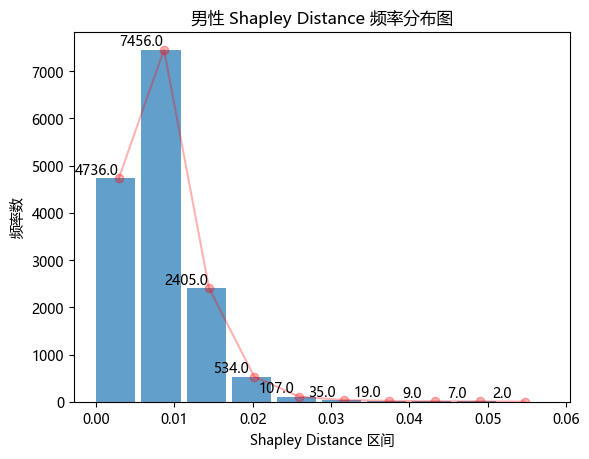

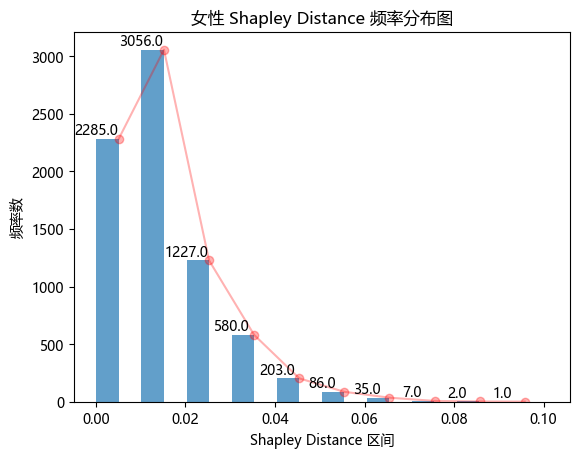

In [14]:
# 可以看到 大于 0.04 的数据比较少，说明不太合理，认为这些是不合理的数据
plt_hist_freq(shap_distance_male, 10, xlabel="Shapley Distance 区间", ylabel="频率数", title="男性 Shapley Distance 频率分布图")
plt_hist_freq(shap_distance_female, 10, xlabel="Shapley Distance 区间", ylabel="频率数", title="女性 Shapley Distance 频率分布图")


In [50]:
# 所以设定阈值为 t=0.04
t = 0.05
# 统计大于阈值的数量
np.sum(shap_distance_male > t), np.sum(shap_distance_female > t)

(4, 140)

In [51]:
knn_k = 9

## 获得公平和不公平的 idx

In [52]:
# 统计大于阈值的 index
unfair_idx_male = np.where(shap_distance_male > t)
fair_idx_male = np.where(shap_distance_male <= t)
assert len(shap_distance_male) == len(unfair_idx_male[0]) + len(
    fair_idx_male[0]
), "和不相等"
# 女性
unfair_idx_female = np.where(shap_distance_female > t)
fair_idx_female = np.where(shap_distance_female <= t)
assert len(shap_distance_female) == len(unfair_idx_female[0]) + len(
    fair_idx_female[0]
), "和不相等"

In [53]:
def index_mapper(a, idx1, idx2):
    """索引映射
    已知 b = a[idx1] 且 c = b[idx2]
    要定位 c 在 a 的位置，则 a[idx1[idx2]]"""
    if isinstance(a, np.ndarray):
        return a[idx1[idx2]]
    elif isinstance(a, pd.DataFrame):
        return a.iloc[idx1[idx2]]
    elif isinstance(a, pd.Series):
        return a.iloc[idx1[idx2]]
    raise BaseException("a 的类型是 ", type(a))

In [54]:
from sklearn.neighbors import NearestNeighbors
def get_knn_idx(knn_k, X_train, X_target):
    knn = NearestNeighbors(n_neighbors=knn_k)
    knn.fit(X_train)
    distance, idx = knn.kneighbors(X_target)
    return idx

In [55]:
# 获得【男性】公平样本和不公平样本
fair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, fair_idx_male)
unfair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, unfair_idx_male)
knn_idx_male = get_knn_idx(knn_k, fair_samples_male, unfair_samples_male)

In [56]:
# 获得【女性】公平样本和不公平样本
fair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, fair_idx_female)
unfair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, unfair_idx_female)
knn_idx_female = get_knn_idx(knn_k, fair_samples_female, unfair_samples_female)

In [57]:
from scipy import stats

def need_modify_idx(target, y_train, idx1, knn_idxs):
    count = 0
    total = len(target)
    unfair_list = []
    # 对于每个不公平样本进行遍历
    for i in range(total):
        # 不公平样本
        unfair_sample_idx = target[i]
        idx2 = idx1[unfair_sample_idx] # unfair_sample 在 X_train 上的 idx
        unfair_sample = index_mapper(y_train, idx1, unfair_sample_idx)

        # 近邻的公平样本
        fair_samples_idx = knn_idxs[i]
        knn_samples = index_mapper(y_train, idx1, fair_samples_idx)

        # 统计计算
        fair_mode = stats.mode(knn_samples).mode
        if fair_mode != unfair_sample:
            count += 1
            unfair_list.append(idx2)
    print(f"总数是 {total}，其中有 {count} 个不同")
    return np.array(unfair_list)
# 获得男性需要改变的 list
unfair_need_modify_male = need_modify_idx(unfair_idx_male[0], y_train, idxs_iloc_in_X_train_male, knn_idx_male)

# 获得女性需要改变的 list
unfair_need_modify_female = need_modify_idx(unfair_idx_female[0], y_train, idxs_iloc_in_X_train_female, knn_idx_female)

总数是 4，其中有 4 个不同
总数是 140，其中有 14 个不同


In [58]:
# 合并向量
percent_m = 1
shape_male = unfair_need_modify_male.shape[0]
shape_female = unfair_need_modify_female.shape[0]
print(shape_male, shape_female)
m = int(min(shape_male, shape_female) * percent_m)
print(m, type(m))
random_index_male = np.random.choice(shape_male, size=m, replace=False)
random_index_female = np.random.choice(shape_female, size=m, replace=False)
unfair_list_np = np.concatenate((unfair_need_modify_male[random_index_male], unfair_need_modify_female[random_index_female]))
unfair_list_np.shape

4 14
4 <class 'int'>


(8,)

In [59]:
y_train_fair = y_train.copy()
y_train_fair.iloc[unfair_list_np] = 1 - y_train.iloc[unfair_list_np]

In [60]:
xgboost_fair, res_fair = train_model_and_test(
    X_train,
    y_train_fair,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="公平组",
)
res_fair

{'准确率[1.]': 0.8625243115979118,
 '精确率[1.]': 0.7610483042137718,
 '召回率[1.]': 0.6278083933870284,
 'FPR[0.]': 0.06275303643724696,
 'FNR[0.]': 0.37219160661297157,
 'F1 Score[1.]': 0.6880371660859466,
 '人口平等 差异[0.]': 0.176091789316427,
 '人口平等 比率[1.]': 0.31876131655495704,
 '机会均等 差异[0.]': 0.07215274303818575,
 '机会均等 比率[1.]': 0.2575415486445543}

In [61]:
df = pd.DataFrame([res_origin, res_fair],index=["origin", "shap-fair"])
df

,准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,0.861194,0.759979,0.621450,0.062483,0.378550,0.683769,0.172093,0.326185,0.084317,0.300440
shap-fair,0.862524,0.761048,0.627808,0.062753,0.372192,0.688037,0.176092,0.318761,0.072153,0.257542


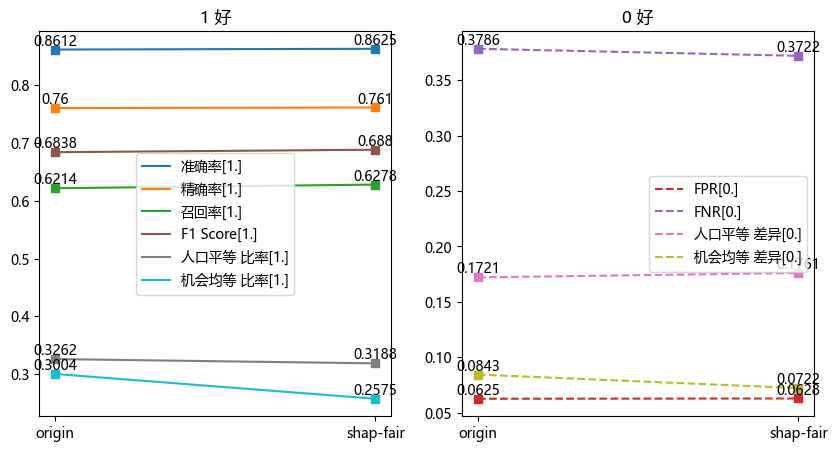

In [62]:
# 画在一张图上
cmap = plt.get_cmap("tab10")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


def plot_sub(ax, title, df: pd.DataFrame, filter, linestyle):
    # 初始化图例对象
    scatter_legend = []
    ax.set_title(title)
    for i, col in enumerate(df.columns):
        if filter(col):
            continue
        values = df[col].values
        x = df.index
        ax.plot(x, values, linestyle=linestyle, label=col, color=cmap(i))
        scatter = ax.scatter(x, values, marker="s", color=cmap(i))
        # 在每个散点的位置添加数值标签
        y = values
        for i in range(len(x)):
            ax.text(x[i], y[i], str(round(y[i], 4)), ha="center", va="bottom")
        # 将散点图的图例对象添加到列表中
        scatter_legend.append(scatter)
    ax.legend()
    # ax.legend(bbox_to_anchor=(1, 1), loc="upper left")


plot_sub(ax1, "1 好", df, lambda x: "1" not in x, "-")
plot_sub(ax2, "0 好", df, lambda x: "0" not in x, "--")

plt.show()